In [1]:
import sys
import os

import matplotlib
import bagpy
from bagpy import bagreader
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

#%matplotlib notebook
# https://stackoverflow.com/questions/39007571/running-jupyter-with-multiple-python-and-ipython-paths
# https://coinsconf.com/cfp2022/

In [2]:
bag_name = "first_fly.bag"
bag_name1 = "second_fly.bag"


def get_csv(bag_name):
    
    data_dict = {}
    
    # Read bag
    b = bagreader(bag_name)
    
    for topic in b.topics: 
        data = b.message_by_topic(topic)
        data_dict['{}'.format(topic)] = pd.read_csv(data)
        
    return data_dict

In [3]:
exp = get_csv(bag_name); exp1 = get_csv(bag_name1)

[INFO]  Data folder first_fly already exists. Not creating.
[INFO]  Data folder second_fly already exists. Not creating.


# Open bags


Method for opening bags that are located in experiments folder. 


In [4]:
def open_bags(dir_path): 
    bags = {}
    bag_names = []
    for bag_name in os.listdir(dir_path): 
        print("[INFO] Bag name is: {}".format(bag_name))
        if not "bag" in bag_name: 
            bag_name = "{}.bag".format(bag_name)
        bag_names.append(bag_name)
        bags["{}".format(bag_name)] = get_csv("{}/{}".format(dir_path, bag_name))
        
    return bag_names, bags

extract_data_from_bags = True
if extract_data_from_bags: 
    bag_names, bags = open_bags("./hpe_paper/experiments")

# How to repair broken bags: http://wiki.ros.org/rosbag/Commandline#reindex
# https://answers.ros.org/question/40116/rosbag-file-cannot-be-made-bagactive/
for bag_name in sorted(bag_names): 
    print(bag_name)

[INFO] Bag name is: 15_00_2022-06-09-16-53-33
[INFO]  Data folder ./hpe_paper/experiments/15_00_2022-06-09-16-53-33 already exists. Not creating.
[INFO] Bag name is: 02_00_2022-04-06-13-02-08
[INFO]  Data folder ./hpe_paper/experiments/02_00_2022-04-06-13-02-08 already exists. Not creating.
[INFO] Bag name is: 07_00_2022-04-11-16-34-53.bag
[INFO]  Data folder ./hpe_paper/experiments/07_00_2022-04-11-16-34-53 already exists. Not creating.
[INFO] Bag name is: 11_00_2022-06-09-11-27-17
[INFO]  Data folder ./hpe_paper/experiments/11_00_2022-06-09-11-27-17 already exists. Not creating.
[INFO] Bag name is: 06_10_2022-04-11-15-07-33
[INFO]  Data folder ./hpe_paper/experiments/06_10_2022-04-11-15-07-33 already exists. Not creating.
[INFO] Bag name is: 10_11_2022-04-11-16-46-59
[INFO]  Data folder ./hpe_paper/experiments/10_11_2022-04-11-16-46-59 already exists. Not creating.
[INFO] Bag name is: 10_00_2022-04-11-17-08-54
[INFO]  Data folder ./hpe_paper/experiments/10_00_2022-04-11-17-08-54 alre

## Utils methods 

* `transform_dict_to_list` --> Transforms dictionary to list 
* `get_flight_duration_from_odom` --> Gets flight duration from odometry reading 



In [5]:
def transform_dict_to_list(dict_): 
    
    list_ = []
    list_of_keys = []
    
    for i, key in enumerate(dict_.keys()): 
        list_of_keys.append(eval(key))
    
    
    for key in sorted(list_of_keys): 
        list_.append(dict_[str(key)])
        
    return list_

def get_flight_duration_from_odom(odometry):
    
    time = odometry['Time']
        
    first_i = time.keys().start
    last_i = time.keys().stop
    
    start_time = time[first_i]
    end_time = time[last_i-1]

    duration = end_time - start_time

    return duration, start_time, end_time 


## Plot methods 

* `plot_2d_trajectory` --> plot 2d trajectory from odometry
* `plot_3d_trajectory` --> plot 3d trajectory from 
* `plot_3d_2d_trajectory` --> plot 3d and 2d trajectory
* `plot_joy` --> plot joystick
* `plot_trajectories` --> plot 3d trajectory and xy trajectory with correct title 
* `plot_joy_comparison` --> create subplot that plots hpe and rc joy alongside 

In [6]:
def plot_2d_trajectory(odometry, multiple=False):
    
    x_pos = odometry['pose.pose.position.x']
    y_pos = odometry['pose.pose.position.y']
    
    if not multiple: 
        plt.figure()
    plt.plot(x_pos, y_pos)
    plt.title('2D trajectory')
    plt.xlabel('X position [m]')
    plt.ylabel('Y position [m]')
    plt.legend(loc="best")
    
def plot_3d_trajectory(odometry, multiple=False):
    
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')    
    
    if type(odometry) == list: 
        x_, y_, z_  = [], [], []
        for odom in odometry: 
            x_.append(odom['pose.pose.position.x'])
            y_.append(odom['pose.pose.position.y'])
            z_.append(odom['pose.pose.position.z'])
        
        cnt = 0
        for x, y, z in zip(x_, y_, z_): 
            cnt += 1
            ax.plot(x, y, z, label="flight_{}".format(cnt))
        plt.legend()
            
            
    else: 
        x_pos = odometry['pose.pose.position.x']
        y_pos = odometry['pose.pose.position.y']
        z_pos = odometry['pose.pose.position.z']        
        ax.plot(x_pos, y_pos, z_pos)
    
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_zlabel('z [m]')
    
    plt.show()  
    
# 2x2 plotting of trajectories 
def plot_3d_2d_trajectories(odometry, multiple=False):

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))    
    
    if type(odometry) == list: 
        x_, y_, z_  = [], [], []
        for odom in odometry: 
            x_.append(odom['pose.pose.position.x'])
            y_.append(odom['pose.pose.position.y'])
            z_.append(odom['pose.pose.position.z'])
        
        cnt = 0
        for x, y, z in zip(x_, y_, z_): 
            cnt += 1
            if cnt == 1:
                ax[0, 0].remove()
                ax_3d = fig.add_subplot(2, 2, 1, projection="3d")                
            ax_3d.plot(x, y, z, label="{}".format(cnt))            
            ax[0, 1].plot(x, y);           
            ax[1, 0].plot(x, z); 
            ax[1, 1].plot(y, z); 
                
        plt.legend()     
            
    else: 
        x = odometry['pose.pose.position.x']
        y = odometry['pose.pose.position.y']
        z = odometry['pose.pose.position.z']
        
        #ax.plot(x_pos, y_pos, z_pos)
        
        ax[0, 0].remove()
        ax_3d = fig.add_subplot(2, 2, 1, projection='3d')        
        # Plot trajectories 
        ax_3d.plot(x, y, z)
        ax[0, 1].plot(x, y); 
        ax[1, 0].plot(x, z); 
        ax[1, 1].plot(y, z); 
    
    # [0, 0]
    ax_3d.set_xlabel('x[m]'); ax_3d.set_ylabel('y[m]'); ax_3d.set_zlabel('z[m]')
    # [0, 1]
    ax[0, 1].grid(); ax[0, 1].set_xlabel('x[m]'); ax[0, 1].set_ylabel('y[m]')
    # [1, 0]
    ax[1, 0].grid(); ax[1, 0].set_xlabel('x[m]'); ax[1, 0].set_ylabel('z[m]')
    # [1, 1]
    ax[1, 1].grid(); ax[1, 1].set_xlabel('y[m]'); ax[1, 1].set_ylabel('z[m]')
    
    plt.title("UAV trajectories")
    plt.show()     
    
        
# 2x2 plotting of trajectories 
def plot_trajectories(odometry, name, xlim=None, ylim=None, multiple=False):
    
    origin_dir = "hpe_paper"

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))    
    
    if type(odometry) == list: 
        x_, y_, z_  = [], [], []
        for odom in odometry: 
            x_.append(odom['pose.pose.position.x'])
            y_.append(odom['pose.pose.position.y'])
            z_.append(odom['pose.pose.position.z'])
        
        cnt = 0
        for x, y, z in zip(x_, y_, z_): 
            cnt += 1
            if cnt == 1:
                ax[0].remove()
                ax_3d = fig.add_subplot(1, 2, 1, projection="3d")                
            ax_3d.plot(x, y, z, label="{}".format(cnt))            
            ax[1].plot(x, y, label="{}".format(cnt));           
                
            
    else: 
        x = odometry['pose.pose.position.x']
        y = odometry['pose.pose.position.y']
        z = odometry['pose.pose.position.z']
        
        #ax.plot(x_pos, y_pos, z_pos)
        
        ax[0].remove()
        ax_3d = fig.add_subplot(1, 2, 1, projection='3d')        
        # Plot trajectories 
        ax_3d.plot(x, y, z)
        ax[1].plot(x, y); 
        #ax[1, 0].plot(x, z); 
        #ax[1, 1].plot(y, z); 
    
    # [0, 0]
    ax_3d.set_xlabel('x[m]', fontsize=10.0); ax_3d.set_ylabel('y[m]', fontsize=10.0);
    ax_3d.set_zlabel('z[m]', fontsize=10.0); ax_3d.set_title('3D trajectory', fontsize=11.0)
    # [0, 1]
    ax[1].grid();
    ax[1].set_xlabel('x[m]', fontsize=10.0); ax[1].set_ylabel('y[m]', fontsize=10.0);
    ax[1].set_title('2D trajectory', fontsize=11); ax[1].legend(loc='best')     

    
    # Define limits :) 
    if xlim: 
        ax[1].set_xlim(xlim[0], xlim[1])
    if ylim: 
        ax[1].set_ylim(ylim[0], ylim[1])
    # [1, 0]
    #ax[1, 0].grid(); ax[1, 0].set_xlabel('x[m]'); ax[1, 0].set_ylabel('z[m]')
    # [1, 1]
    #ax[1, 1].grid(); ax[1, 1].set_xlabel('y[m]'); ax[1, 1].set_ylabel('z[m]')
    
    fig.suptitle("UAV {}".format(name), fontsize=12)
    
    fig.savefig("./{}/{}.svg".format(origin_dir, name))
    plt.show() 
    
def plot_height(odometry, multiple=False): 
    
    plt.figure()
    if (type(odometry)) == list: 
        z_, time_ = [], []
        
        # Maybe add some minor data processing 
        for odom in odometry: 
            z_.append(odom['pose.pose.position.z'])
            time_.append(odom['Time'])  
        
        cnt = 0
        for t, z in zip(time_, z_): 
            cnt += 1
            plt.plot(t, z, label="{}".format(cnt))
            
    else: 
        
        z_ = odometry['pose.pose.position.z']
        t_ = odometry['Time']
        plt.plot(t, z)
    
    plt.legend(loc="best")     
    plt.grid()
    plt.xlabel("Time [t]")
    plt.ylabel("z [m]")
    plt.title("UAV altitude")
    plt.show()
        
    
def plot_joy(joy, multiple=False):
    """
    roll:   2
    pitch:  3
    yaw:    0 
    height: 1
    """
    joy_axes0 = joy['axes_0']
    joy_axes1 = joy['axes_1']
    joy_axes2 = joy['axes_2']
    joy_axes3 = joy['axes_3']
    time = joy['Time']
    
    if not multiple: 
        plt.figure()
    
    plt.title("Joystick output")
    plt.plot(time, joy_axes0, label="yaw");
    plt.plot(time, joy_axes1, label="z");
    plt.plot(time, joy_axes2, label="roll");
    plt.plot(time, joy_axes3, label="pitch");
    
    plt.legend(loc="best")
    
def plot_joy_comparison(joy1, joy2, pId):
    
    time1 = joy1['Time']; time2 = joy2['Time']
    # HPE
    joy11 = joy1['axes_0']; joy21 = joy2['axes_0']
    joy12 = joy1['axes_1']; joy22 = joy2['axes_1']
    joy13 = joy1['axes_2']; joy23 = joy2['axes_2']
    joy14 = joy1['axes_3']; joy24 = joy2['axes_3']
    
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    
    fig.suptitle('Input comparison participant {}'.format(pId)) # or plt.suptitle('Main title')
    
    ax[0].plot(time1, joy11, label="yaw");  ax[0].plot(time1, joy12, label="z"); 
    ax[0].plot(time1, joy13, label="roll"); ax[0].plot(time1, joy14, label="pitch"); 
    ax[1].plot(time2, joy21, label="yaw"); ax[1].plot(time2, joy22, label="z"); 
    ax[1].plot(time2, joy23, label="roll"); ax[1].plot(time2, joy24, label="pitch"); 
    ax[0].grid(); ax[0].set_xlabel('t [s]'); ax[0].set_title('HPE joystick'); ax[0].legend(loc="best")
    ax[1].grid(); ax[1].set_xlabel('t [s]'); ax[1].set_title('RC joystick'); ax[1].legend(loc="best")
    
    hpe = [joy11, joy12, joy13, joy14]
    rc = [joy21, joy22, joy23, joy24]
    
    return hpe, rc
    
def get_joy_params(joy): 
    
    time = joy['Time']
    start_time = time[0]
    end_time = time[len(time)-1]
    
    duration = end_time - start_time
    
    joy_axes0 = joy['axes_0']
    joy_axes1 = joy['axes_1']
    joy_axes2 = joy['axes_2']
    joy_axes3 = joy['axes_3']
    
    sum_axes0 = sum(joy_axes0) 
    sum_axes1 = sum(joy_axes1)
    sum_axes2 = sum(joy_axes2)
    sum_axes3 = sum(joy_axes3)
    
    sum_axes = sum([sum_axes0, sum_axes1, sum_axes2, sum_axes3])
    
    return sum_axes, sum_axes0, sum_axes1, sum_axes2, sum_axes3, duration            
    

In [7]:
# Bags are opened
def extract_data(bags, return_all = False): 
    
    data = {}
    
    hpe_odometries, hpe_joys, hpe_durations = {}, {}, {}
    rc_odometries, rc_joys, rc_durations = {}, {}, {}
    user_ids = []
    
    print("[INFO] Total number of bags is: {}".format(len(bags.keys())))
    
    for bag_name in sorted(bags.keys()): 
        
        print(bag_name)
        
        list_of_tokens = bag_name.split("_")
        
        if list_of_tokens[0][0] == "0":
            user_id = list_of_tokens[0][1]
        
        else:
            
            user_id = list_of_tokens[0] 
        
        user_ids.append(eval(user_id))
        
        
        if eval(list_of_tokens[1][0]) == 1: 
            task = "hpe"
        
        if eval(list_of_tokens[1][0]) == 0:
            task = "rc"             
            
        print("[INFO] Bag name {} is : {}".format(bag_name, task))
            
        try:
            start_time = bags[bag_name]['/start_time']['data.secs'][0]
        except Exception as e: 
            start_time = None
            print(str(e))
        
        odom_ = bags[bag_name]['/bebop/odometry']
        joy_ = bags[bag_name]['/joy']
        
        data['{}_{}_odometry'.format(user_id, task)] = odom_
        data['{}_{}_joy'.format(user_id, task)] = joy_
        
        if task == "hpe": 
            hpe_odometries['{}'.format(eval(user_id))] = odom_
            hpe_joys['{}'.format(eval(user_id))] = joy_ 
        
        if task == "rc": 
            rc_odometries['{}'.format(eval(user_id))] = odom_
            rc_joys['{}'.format(eval(user_id))] = joy_
            
    if return_all: 
        print("[INFO] Total number of rc bags is: {}".format(len(rc_odometries)))
        print("[INFO] Total number of hpe bags is: {}".format(len(hpe_odometries)))
        return hpe_odometries, hpe_joys, rc_odometries, rc_joys, user_ids
    
    else: 
        return data

hpe_odometries, hpe_joys, rc_odometries, rc_joys, uids = extract_data(bags, return_all = True)


[INFO] Total number of bags is: 24
00_00_01_04.bag
[INFO] Bag name 00_00_01_04.bag is : rc
00_10_01_04.bag
[INFO] Bag name 00_10_01_04.bag is : hpe
'/start_time'
01_00_2022-04-06-12-24-41.bag
[INFO] Bag name 01_00_2022-04-06-12-24-41.bag is : rc
01_11_2022-04-06-12-47-48.bag
[INFO] Bag name 01_11_2022-04-06-12-47-48.bag is : hpe
'/start_time'
02_00_2022-04-06-13-02-08.bag
[INFO] Bag name 02_00_2022-04-06-13-02-08.bag is : rc
02_12_2022-04-06-13-23-41.bag
[INFO] Bag name 02_12_2022-04-06-13-23-41.bag is : hpe
04_00_2022-04-08-16-43-36.bag
[INFO] Bag name 04_00_2022-04-08-16-43-36.bag is : rc
04_11_2022-04-08-17-03-10.bag
[INFO] Bag name 04_11_2022-04-08-17-03-10.bag is : hpe
06_00_2022-04-11-14-57-54.bag
[INFO] Bag name 06_00_2022-04-11-14-57-54.bag is : rc
06_10_2022-04-11-15-07-33.bag
[INFO] Bag name 06_10_2022-04-11-15-07-33.bag is : hpe
07_00_2022-04-11-16-34-53.bag
[INFO] Bag name 07_00_2022-04-11-16-34-53.bag is : rc
07_12_2022-04-11-16-58-09.bag
[INFO] Bag name 07_12_2022-04-11-1

In [8]:
def edit_odom_dict(odom_dict, key_edit): 
    
    start_x_cond, end_x_cond = -0.5, 9.75
    start_y_cond, end_y_cond = 0, -1 
    
    odom_ = odom_dict['{}'.format(key_edit)]
    
    try:
        time = odom_dict['{}'.format(key_edit)]['Time']
    except Exception: 
        print(odom_dict['{}'.format(key_edit)])    
    

    index_start = get_index_where_condition_first_satisfied(odom_, time, start_x_cond, start_y_cond, start=True)
    index_end = get_index_where_condition_first_satisfied(odom_, time, end_x_cond, end_y_cond, start=False)
    
    odom = odom_.truncate(before=int(index_start), after=int(index_end))
    
    return odom

# Get start and end time to crop joysticks 
def get_start_and_end_time_from_odom(odom_dict, key_edit):
    
    start_x_cond, end_x_cond = -0.5, 9.75
    start_y_cond, end_y_cond = 0, -1 
    
    odom_ = odom_dict['{}'.format(key_edit)]
    time_ = odom_['Time']

    
    index_start = get_index_where_condition_first_satisfied(odom_, time_, start_x_cond, start_y_cond, start=True)
    index_end = get_index_where_condition_first_satisfied(odom_, time_, end_x_cond, end_y_cond, start=False)
    
    
    start_time = time_[index_start]
    end_time = time_[index_end-1]
    
    return start_time, end_time
    
def get_index_where_condition_first_satisfied(odom, time, x_condition, y_condition, start=False): 
    
    x_ = list(odom['pose.pose.position.x'])
    y_ = list(odom['pose.pose.position.y'])
    z_ = list(odom['pose.pose.position.z'])
    
    condition_satisfied = False
    
    if start: 
        for x, y, z in zip(x_, y_, z_): 
            if x > x_condition and y > y_condition: 
                index = x_.index(x)
                condition_satisfied = True

                break       
    
    if not start: 
        for x, y, z in zip(x_, y_, z_): 
            if x > x_condition and y < y_condition: 
                index = x_.index(x)
                condition_satisfied = True

                break
    
    if condition_satisfied:
        if start:
            print("[INFO] Start index is: {}/{}".format(index, len(x_)))
        else: 
            print("[INFO] End index is: {}/{}".format(index, len(x_)))

    else: 
        index = len(x_)
        
    return index

# TODO: Crop based on durations
def crop_based_on_time(series, start_time, end_time): 
    
    time_ = series['Time']    
    
    # Start index
    min_diff = 1
    for i, t in enumerate(time_):
        if abs(start_time - t) < abs(min_diff): 
            min_diff = start_time - t
            start_index = i
        else: 
            continue
            
    for i, t in enumerate(time_): 
        if abs(end_time - t) < abs(min_diff): 
            min_diff = end_time - t
            end_index = i
        else: 
            end_index = i
            
    series_ = series.truncate(before=start_index, after=end_index)
    
    debug = True
    if debug: 
        print("[INFO] Whole series is: {}".format(len(series)))
        print("[INFO] Truncated series is: {}".format(len(series_)))            
        
    return series_    

debug = False
hpe_durations, rc_durations = {}, {}
hpe_times, rc_times = {}, {}
hpe_corrected, rc_corrected = {}, {}
for key in sorted(hpe_odometries.keys()): 
    if debug: 
        print("[INFO] HPE participant {}".format(key))
        print("======================================")
    start_time, end_time = get_start_and_end_time_from_odom(hpe_odometries, key)
    hpe_durations['{}'.format(key)] = end_time - start_time
    hpe_corrected['{}'.format(key)] = crop_based_on_time(hpe_joys['{}'.format(key)], start_time, end_time)
    hpe_odometries['{}'.format(key)] = edit_odom_dict(hpe_odometries, key)    
    
for key in sorted(rc_odometries.keys()):
    if debug: 
        print("[INFO] RC participant {}".format(key))
        print("======================================")
    start_time, end_time = get_start_and_end_time_from_odom(rc_odometries, key)
    rc_durations['{}'.format(key)] = end_time - start_time
    rc_corrected['{}'.format(key)] = crop_based_on_time(rc_joys['{}'.format(key)], start_time, end_time)
    rc_odometries['{}'.format(key)] = edit_odom_dict(rc_odometries, key)
    

[INFO] Start index is: 22167/39486
[INFO] End index is: 39233/39486
[INFO] Whole series is: 1775
[INFO] Truncated series is: 869
[INFO] Start index is: 22167/39486
[INFO] End index is: 39233/39486
[INFO] Start index is: 33874/139746
[INFO] End index is: 63725/139746
[INFO] Whole series is: 5927
[INFO] Truncated series is: 5305
[INFO] Start index is: 33874/139746
[INFO] End index is: 63725/139746
[INFO] Start index is: 9938/36263
[INFO] End index is: 35872/36263
[INFO] Whole series is: 1629
[INFO] Truncated series is: 1321
[INFO] Start index is: 9938/36263
[INFO] End index is: 35872/36263
[INFO] Start index is: 10982/20319
[INFO] Whole series is: 845
[INFO] Truncated series is: 468
[INFO] Start index is: 10982/20319
[INFO] Start index is: 24406/45234
[INFO] Whole series is: 2090
[INFO] Truncated series is: 1048
[INFO] Start index is: 24406/45234
[INFO] Start index is: 11721/39762
[INFO] Whole series is: 1749
[INFO] Truncated series is: 1406
[INFO] Start index is: 11721/39762
[INFO] Star

## Measured duration time difference between different control modalities


In this plot, we present duration difference as follows: 
 * $t_{\Delta} = t_h - t_{rc}$

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


12
12
Fast RC participant is: 9
Fast HPE participant is: 10
R durations: 71.217	 H durations: 85.51999999999998
R durations: 75.836	 H durations: 149.53000000000003
R durations: 92.407	 H durations: 208.091
R durations: 93.12800000000001	 H durations: 114.489
R durations: 44.381	 H durations: 85.57999999999998
R durations: 65.326	 H durations: 113.975
R durations: 93.47	 H durations: 130.083
R durations: 73.63900000000001	 H durations: 46.750000000000014
R durations: 46.911	 H durations: 104.67200000000003
R durations: 37.592	 H durations: 140.483
R durations: 68.076	 H durations: 31.26100000000001
R durations: 55.637000000000015	 H durations: 116.136


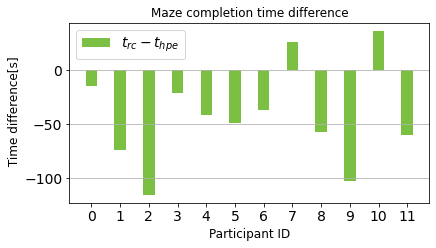

In [65]:
# Transform them to dict 
h_odom_ = transform_dict_to_list(hpe_odometries)
h_joy_ = transform_dict_to_list(hpe_corrected)
h_durations_ = transform_dict_to_list(hpe_durations)
h_durations_sec = h_durations_
#h_durations_sec = [i[0] for i in h_durations_]
r_odom_ = transform_dict_to_list(rc_odometries)
r_joy_ = transform_dict_to_list(rc_corrected)
r_durations_ = transform_dict_to_list(rc_durations)
r_durations_sec = r_durations_
#r_durations_sec = [i[0] for i in r_durations_]

print(len(r_durations_sec))
print(len(h_durations_sec))

# Get fastest participants based on (end_recording_time - start_time)
fastest_rc_participant = r_durations_sec.index(min(r_durations_sec))
fastest_hpe_participant = h_durations_sec.index(min(h_durations_sec))

print("Fast RC participant is: {}".format(round(fastest_rc_participant, 2)))
print("Fast HPE participant is: {}".format(round(fastest_hpe_participant,2)))

for i, j in zip (r_durations_sec, h_durations_sec): 
    print("R durations: {}\t H durations: {}".format(i, j))

# Get time difference 
time_difference = [round(i - j, 2) for i, j in zip(r_durations_sec, h_durations_sec)]

# Plot bar graph of time difference
origin_dir = "hpe_paper"
X = np.arange(len(time_difference)) 
fig = plt.figure(figsize=(5, 2.5))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(X , time_difference, color="#7bc043", width=0.4)
ax.grid(axis="y")
ax.set_title("Maze completion time difference", fontsize=12)
ax.set_xlabel("Participant ID", fontsize=12)
ax.set_ylabel(" Time difference[s]", fontsize=12)
ax.set_xticks(range(max(X)+1))
ax.legend(labels=["$t_{rc} - t_{hpe}$"])
fig.savefig("./{}/time_difference.svg".format(origin_dir))

In [10]:
# Plot RC and HPE durations 

# r_durations_sec, h_durations_sec

# Trajectories plot

## TODO: 
- [ ] Repeat 10th value
- [ ] Huge time difference for 3rd candidate?! 


<Figure size 432x288 with 0 Axes>

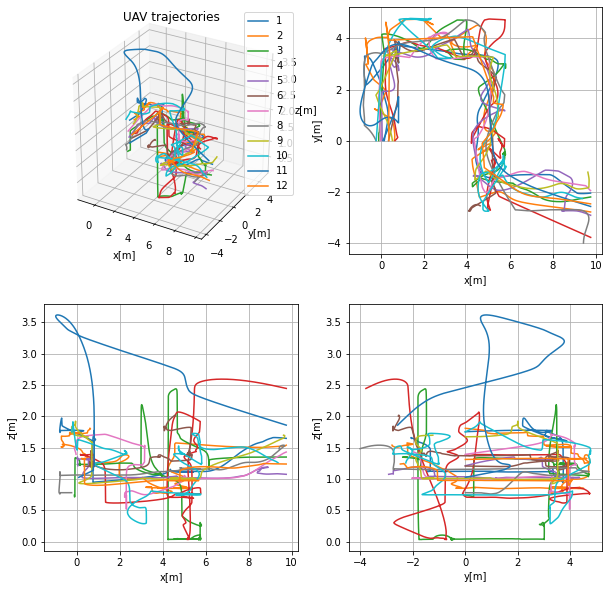

<Figure size 432x288 with 0 Axes>

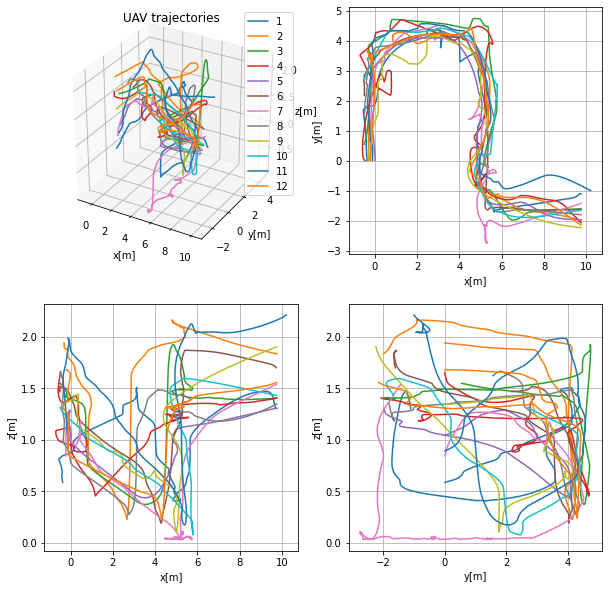

In [11]:
plt.figure()
plot_3d_2d_trajectories(h_odom_)

plt.figure()
plot_3d_2d_trajectories(r_odom_)

<Figure size 432x288 with 0 Axes>

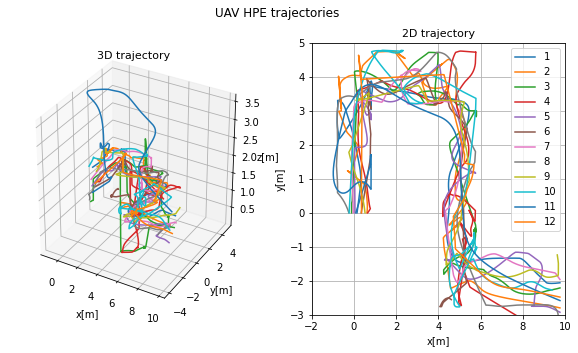

<Figure size 432x288 with 0 Axes>

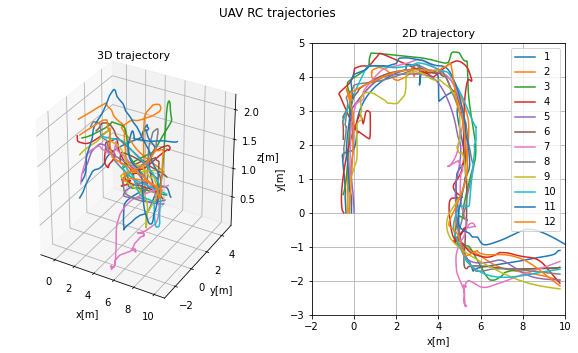

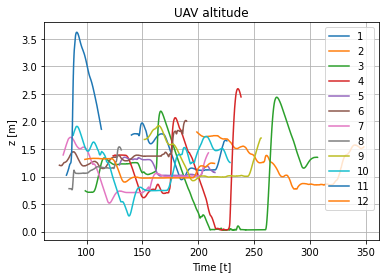

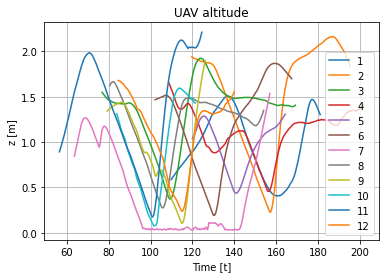

In [12]:
plt.figure()
plot_trajectories(h_odom_, "HPE trajectories", xlim=(-2, 10), ylim=(-3, 5))

plt.figure()
plot_trajectories(r_odom_,  "RC trajectories", xlim=(-2, 10), ylim=(-3, 5))

plot_height(h_odom_)
plot_height(r_odom_)

## Smoothnes 

Interesting topic about curve smoothnes on stackexchange can be found [here](https://math.stackexchange.com/questions/1369155/how-do-i-rate-smoothness-of-discretely-sampled-data-picture).

More about using `scipy` for interpolation can be found [here](https://docs.scipy.org/doc/scipy/tutorial/interpolate.html). 

More about cubic spline interpolation can be found [here](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter17.03-Cubic-Spline-Interpolation.html). 

More about interpolation in scipy can be found [here](https://docs.scipy.org/doc/scipy/tutorial/interpolate.html). 


In [13]:
from scipy.interpolate import CubicSpline, UnivariateSpline 


odom1 = h_odom_[0]
odom2 = r_odom_[0]

t_ = [t for t in h_odom_[0]['Time']]

def remove_duplicate(list_):
    
    first = True
    new_list, indexes_to_remove = [], []
    
    for i, element in enumerate(list_): 
        if first: 
            new_list.append(element)
            first = False
        else: 
            if element == new_list[-1]: 
                indexes_to_remove.append(i)
            else: 
                new_list.append(element)
                
    return indexes_to_remove
    


In [14]:
create_figure()
plt.plot(t_, x_, label="real_trajectory")
plt.plot(t_, cs1(t_), label="cubic interpolation")
create_figure()
plt.plot(t_, cs1(t_, 1), label="first_derivative")
#create_figure()
#plt.plot(t_, cs1(t_, 2), label="second_derivative")

create_figure()
plt.plot(t_, y_, label="real_trajectory")
plt.plot(t_, cs2(t_), label="cubic_interpolation")
create_figure()
plt.plot(t_, cs2(t_, 1), label="first_derivative")
#create_figure()
#plt.plot(t_, cs2(t_, 2), label="second_derivative")

NameError: name 'create_figure' is not defined

In [15]:
def create_figure(x_size=15, y_size=5): 
    plt.figure(figsize=(x_size, y_size))
    plt.grid()
    
def preprocess_data(t, x, y): 
     
    indexes_to_remove = remove_duplicate(t)
    
    t_ = [j for i, j in enumerate(t) if i not in indexes_to_remove]
    x_ = [x for i, x in enumerate(x) if i not in indexes_to_remove]
    y_ = [y for i, y in enumerate(y) if i not in indexes_to_remove]
    
    return t_, x_, y_

    
def return_energy(t_sampled, dd):
    
    w_ = 0
    for k, t in enumerate(t_sampled): 
        
        if k > 0 and k < len(t_sampled): 
            
            lk = t_sampled[k] - t_sampled[k-1] 
            
            w_k = lk * (dd[k-1]**2 + dd[k]*dd[k-1] + dd[k]**2)

            w_ += w_k
            
        w = w_/6
    
    return w


def get_curve_bending_energy(t, x, y, t_inv=0.1, preprocess=True):
    
    # Preprocess data (remove duplicates from measurements)
    if preprocess:
        t, x, y = preprocess_data(t, x, y)
    
    #print("length of x is: {}".format(len(x)))
    #print("length of y is: {}".format(len(y)))
    
    #t_inv = (max(t) - min(t))/len(t)
    #print(t_inv)
    
    x_array = np.array(x); y_array = np.array(y)
    xy = np.stack([x_array, y_array], axis=1)
    t = np.array(t)
    
    #print(xy.shape)
    #print(t.shape)
    
    csx = CubicSpline(t, x)
    csy = CubicSpline(t, y)
    cs = CubicSpline(t, xy)
    
    # Sample time in wanted time intervals 
    t_sampled = np.arange(min(t), max(t), t_inv)
    
    # if plot, plot curves with interpolation
    plot = False
    if plot: 
        plt.figure(figsize=(15, 5))
        plt.plot(t, x)
        plt.plot(t, y)
        plt.plot(t_sampled, csx(t_sampled), label="x_i")
        plt.plot(t_sampled, csy(t_sampled), label="y_i")
    
    # Using Bernoulli's Beam theory and cubic spline interpolation, return energy required to bend curve, 
    # Larger energy, more curves, get second derivatives    
    n_dd = cs(t_sampled, 2)
    #x_dd = csx(t_sampled, 2)
    #y_dd = csy(t_sampled, 2)    
    #x_e = return_energy(t_sampled, x_dd)
    #y_e = return_energy(t_sampled, y_dd)
    
    e = sum(return_energy(t_sampled, n_dd))   
    
    print("full energy is: {}".format(e))
    
    return cs, e


def get_curve_bending_energy_from_odom(odom, t_inv=0.1): 
    
    t_ = [t for t in odom['Time']]
    x_ = [x for x in odom['pose.pose.position.x']]
    y_ = [y for y in odom['pose.pose.position.y']]
    
    cs, e = get_curve_bending_energy(t_, x_, y_, t_inv, preprocess=True)   

    return cs, e


#x_bending_eng = return_energy(t_sampled, csx)
#y_bending_eng = return_energy(t_sampled, csy)


cs, h_cbe = get_curve_bending_energy_from_odom(h_odom_[1], 0.25)
cs, r_cbe = get_curve_bending_energy_from_odom(r_odom_[1], 0.25)

cs, h_cbe = get_curve_bending_energy_from_odom(h_odom_[2], 0.25)
cs, r_cbe = get_curve_bending_energy_from_odom(r_odom_[2], 0.25)


full energy is: 12838227.388860479
full energy is: 1330566.9309073938
full energy is: 3523318.5433241744
full energy is: 1915688.6643469427


In [ ]:
h_energies, r_energies = [], []
h_css, r_css = [], []
for h_odom in h_odom_: 
    h_css_, h_eng_,  = get_curve_bending_energy_from_odom(h_odom, 0.25)
    h_energies.append(h_eng_)
    h_css.append(h_css_)

for r_odom in r_odom_: 
    r_css_, r_eng_ = get_curve_bending_energy_from_odom(r_odom, 0.25)
    r_energies.append(r_eng_)
    r_css.append(r_css_)

In [ ]:
X = np.arange(0, len(h_energies), 1)
plt.figure()
plt.plot(X, h_energies, label="h")
plt.plot(X, r_energies, label="r")
plt.legend()



<Figure size 432x288 with 0 Axes>

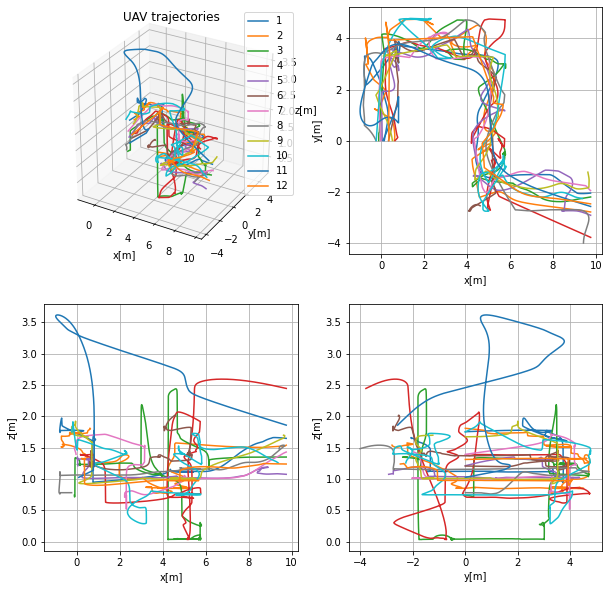

<Figure size 432x288 with 0 Axes>

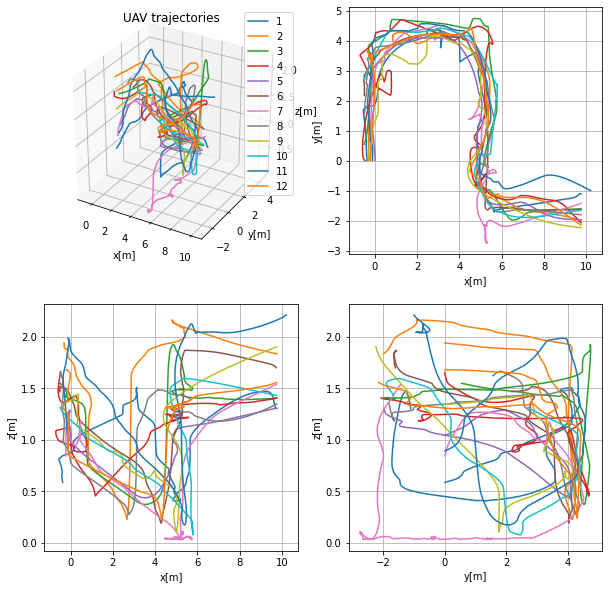

In [16]:
plt.figure()
plot_3d_2d_trajectories(h_odom_)

plt.figure()
plot_3d_2d_trajectories(r_odom_)

# Throw out 4, 7, 10

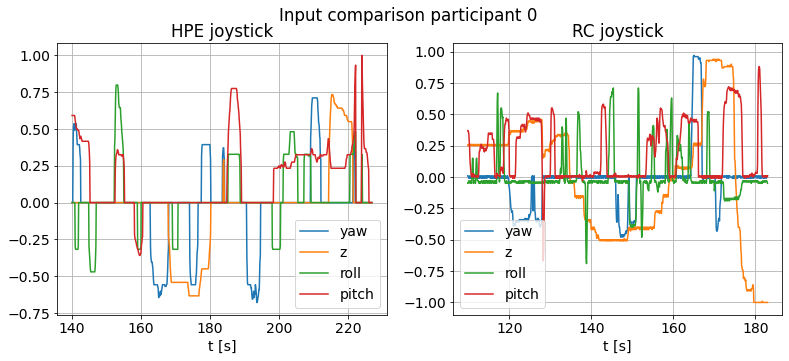

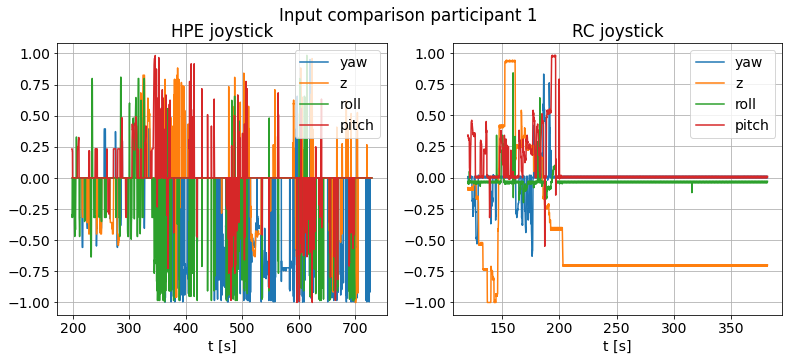

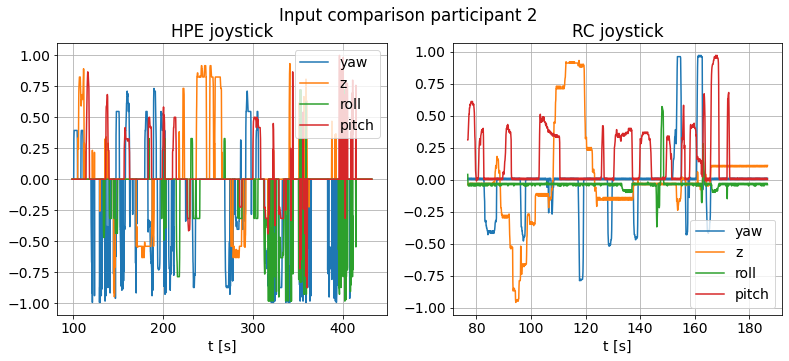

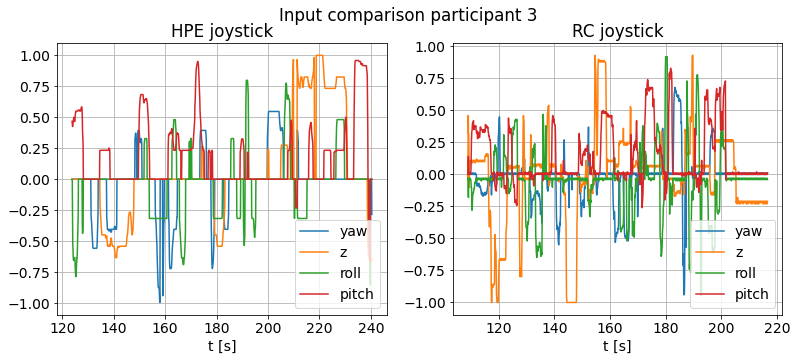

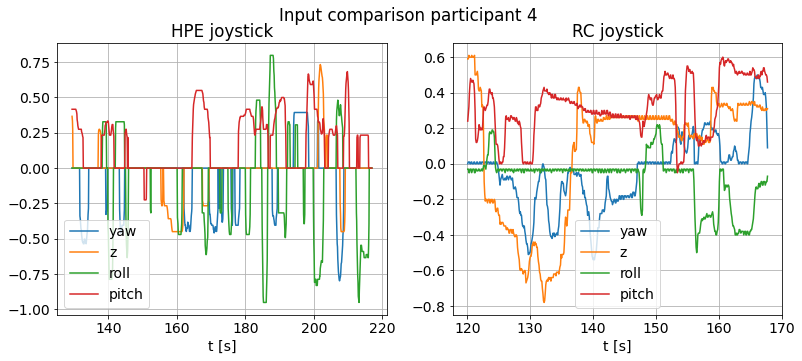

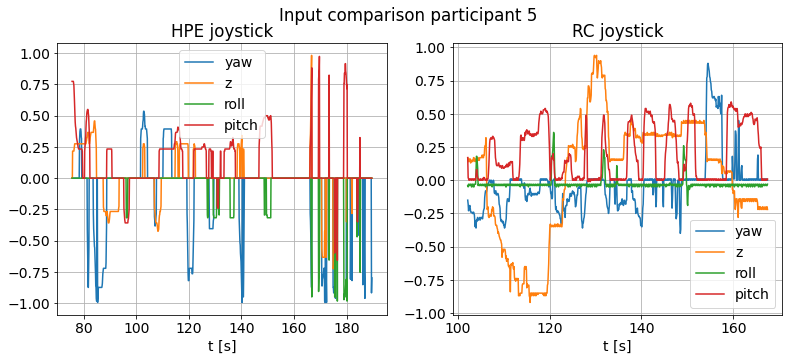

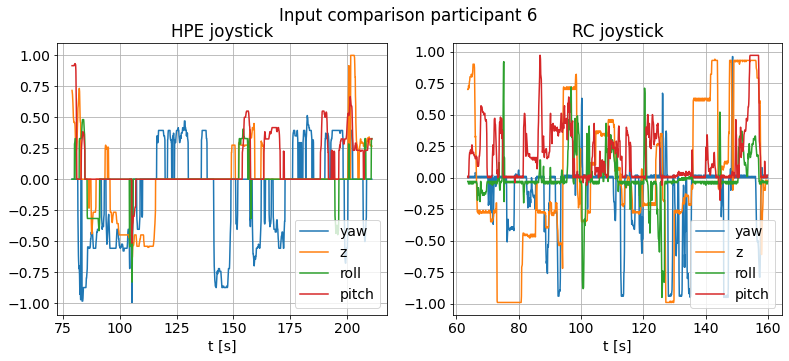

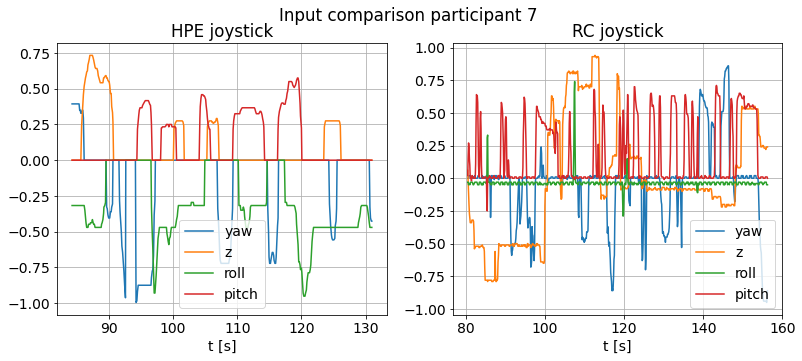

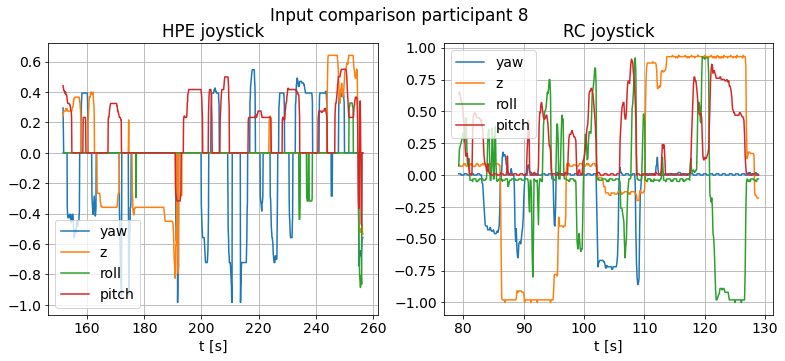

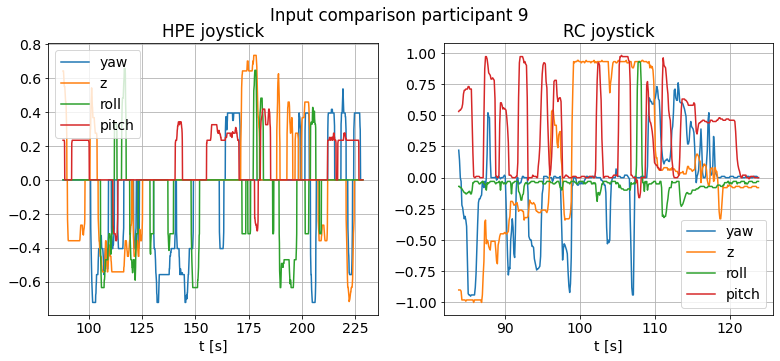

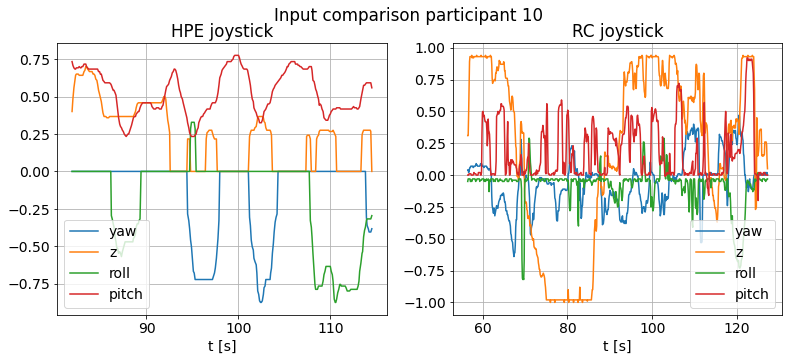

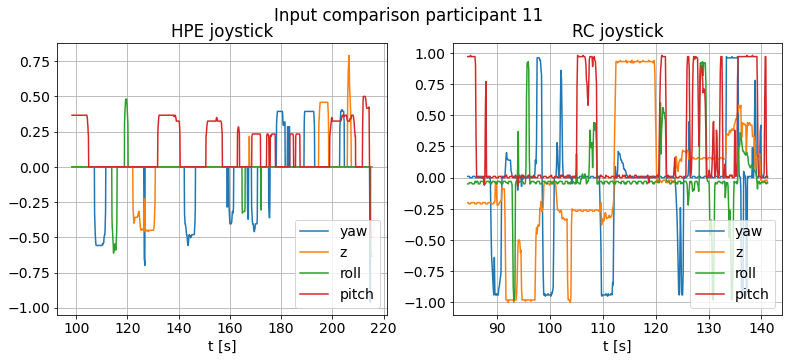

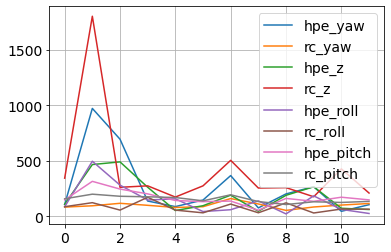

In [53]:
hpe0, rc0 = plot_joy_comparison(h_joy_[0], r_joy_[0], 0)
hpe1, rc1 = plot_joy_comparison(h_joy_[1], r_joy_[1], 1)
hpe2, rc2 = plot_joy_comparison(h_joy_[2], r_joy_[2], 2)
hpe3, rc3 = plot_joy_comparison(h_joy_[3], r_joy_[3], 3)
hpe4, rc4 = plot_joy_comparison(h_joy_[4], r_joy_[4], 4)
hpe5, rc5 = plot_joy_comparison(h_joy_[5], r_joy_[5], 5)
hpe6, rc6 = plot_joy_comparison(h_joy_[6], r_joy_[6], 6)
hpe7, rc7 = plot_joy_comparison(h_joy_[7], r_joy_[7], 7)
hpe8, rc8 = plot_joy_comparison(h_joy_[8], r_joy_[8], 8)
hpe9, rc9 = plot_joy_comparison(h_joy_[9], r_joy_[9], 9)
hpe10, rc10 = plot_joy_comparison(h_joy_[10], r_joy_[10], 10)
hpe11, rc11 = plot_joy_comparison(h_joy_[11], r_joy_[11], 11)

def get_integral(joy):

    joy11 = joy['axes_0']; # yaw
    joy12 = joy['axes_1']; # z
    joy13 = joy['axes_2']; # roll 
    joy14 = joy['axes_3']; # pitch
    
    sum1 = sum(abs(joy11))
    sum2 = sum(abs(joy12))
    sum3 = sum(abs(joy13))
    sum4 = sum(abs(joy14))
    
    return sum1, sum2, sum3, sum4

h_yaw, h_z, h_roll, h_pitch = [], [], [], []
r_yaw, r_z, r_roll, r_pitch = [], [], [], []

for h_joy_meas in h_joy_: 
    h_yaw_, h_z_, h_roll_, h_pitch_ = get_integral(h_joy_meas)
    h_yaw.append(h_yaw_); h_z.append(h_z_); h_roll.append(h_roll_); h_pitch.append(h_pitch_)
    
for r_joy_meas in r_joy_: 
    r_yaw_, r_z_, r_roll_, r_pitch_ = get_integral(r_joy_meas)
    r_yaw.append(r_yaw_); r_z.append(r_z_); r_roll.append(r_roll_); r_pitch.append(r_pitch_)
    
plt.figure()
plt.plot(np.arange(len(h_yaw)), h_yaw, label="hpe_yaw")
plt.plot(np.arange(len(r_yaw)), r_yaw, label="rc_yaw")
plt.plot(np.arange(len(h_yaw)), h_z, label="hpe_z")
plt.plot(np.arange(len(r_yaw)), r_z, label="rc_z")
plt.plot(np.arange(len(h_yaw)), h_roll, label="hpe_roll")
plt.plot(np.arange(len(r_yaw)), r_roll, label="rc_roll")
plt.plot(np.arange(len(h_yaw)), h_pitch, label="hpe_pitch")
plt.plot(np.arange(len(r_yaw)), r_pitch, label="rc_pitch")
plt.grid()
plt.legend()

    

# What happened to participant 1? 
# Maybe plot fastest and slowest participants, comparison, or faster RC and faster HPE 

# Bar plot for evaluating human ratings using NASA TLX

NASA TLX is comprised of following elements: 
 1. Mental demand
 2. Physical demand
 3. Temporal demand
 4. Effort
 5. Frustration 
 6. Performance


In [54]:
def plot_bars(rc_raw, hpe_raw, rc_w, hpe_w, task="overall"): 
    
    #assert len(rc_raw) == len(hpe_raw) and len(hpe_w) == len(rc_w): 
    #    print("Please check lenght of inputs!")
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))    
    
    X = np.arange(len(rc_raw))
    
    ax[0].bar(X - 0.2, rc_raw, color="#7bc043", width=0.4)
    ax[0].bar(X + 0.2, hpe_raw, color="#fdf498", width=0.4)
    ax[0].grid(axis="y")
    ax[0].set_title("Raw {} ratings".format(task), fontsize=11.0)
    ax[0].set_xlabel("Participant ID", fontsize=10.0)
    ax[0].set_ylabel("Raw Rating", fontsize=10.0)
    ax[0].legend(labels=["RC", "HPE"])
    ax[0].set_xticks(max(X))

    ax[1].bar(X - 0.2, rc_w, color="#fe4a49", width=0.4)
    ax[1].bar(X + 0.2, hpe_w, color="#2ab7ca", width=0.4)
    ax[1].grid(axis="y")
    ax[1].set_title("Adjusted {} ratings".format(task), fontsize=11.0)
    ax[1].set_xlabel("Participant ID", fontsize=10.0)
    ax[1].set_ylabel("Adjusted Rating", fontsize=10.0)
    ax[1].legend(labels=["RC", "HPE"])
    ax[1].set_xticks(max(X)+1)

    fig.savefig("./{}/{}.svg".format(origin_dir, task))

# For everything will plot bar be used
def plot_bar(rc_raw, hpe_raw, origin_dir, task="overall",): 
    
    fig = plt.figure()
    
    X = np.arange(len(rc_raw))
    plt.bar(X - 0.2, rc_raw, color="#fe4a49", width=0.4)
    plt.bar(X + 0.2, hpe_raw, color="#2ab7ca", width=0.4)
    plt.grid(axis="y")
    plt.title("Raw {} ratings".format(task), fontsize=13.0)
    plt.xlabel("Participant ID", fontsize=13.0)
    plt.ylabel("Raw Rating", fontsize=13.0)
    plt.legend(labels=["RC", "HPE"])
    plt.xticks(range(max(X)+1))
    fig.savefig("./{}/{}.svg".format(origin_dir, task))

    

def plot_normalized_bars(rc_raw, hpe_raw, rc_w, hpe_w, task="overall"): 
    
    #assert len(rc_raw) == len(hpe_raw) and len(hpe_w) == len(rc_w): 
    #    print("Please check lenght of inputs!")
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))    
    
    X = np.arange(len(rc_raw))
    
    ax[0].bar(X - 0.2, rc_raw, color="#7bc043", width=0.4)
    ax[0].bar(X + 0.2, hpe_raw, color="#fdf498", width=0.4)
    ax[0].grid(axis="y")
    ax[0].set_title("Raw {} ratings".format(task), fontsize=12)
    ax[0].set_xlabel("Participant ID", fontsize=12.0)
    ax[0].set_ylabel("Raw Rating", fontsize=12.0)
    ax[0].set_xticks(range(max(X)+1))
    ax[0].legend(labels=["Normalized Raw Rating difference", "Normalized time difference"])

    ax[1].bar(X - 0.2, rc_w, color="#fe4a49", width=0.4)
    ax[1].bar(X + 0.2, hpe_w, color="#2ab7ca", width=0.4)
    ax[1].grid(axis="y")
    ax[1].set_title("Adjusted {} ratings".format(task), fontsize=12)
    ax[1].set_xlabel("Participant ID", fontsize=12.0)
    ax[1].set_ylabel("Adjusted Rating", fontsize=12.0)
    ax[1].set_xticks(range(max(X)+1))
    ax[1].legend(labels=["Normalized Adjusted Rating Difference", "Normalized time difference"])

    fig.savefig("./{}/{}.svg".format(origin_dir, task))

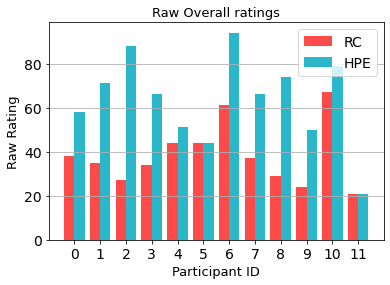

In [55]:
origin_dir = "hpe_paper"

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)


X = np.arange(15)

# Raw rating 
rc_raw_ratings = [38, 35, 27, 34, 44, 44, 61, 37, 29, 24, 67, 21]
hpe_raw_ratings = [58, 71, 88, 66, 51, 44, 94, 66, 74, 50, 79, 21] 


# Nice colors for plots can be found here: https://digitalsynopsis.com/design/beautiful-color-palettes-combinations-schemes/
# plot_bars(rc_raw_ratings, hpe_raw_ratings, rc_w_ratings, hpe_w_ratings, "Overall")
plot_bar(rc_raw_ratings, hpe_raw_ratings, origin_dir, "Overall")


#https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot

## NASA Overall score: 

- 9/10 participants found RC control has less task load than HPE control 
- 8/10 participants found RC control less task load heavy than HPE control when taking subjective importance of different task loads 

In [56]:
abs_td = [abs(i) for i in time_difference]
min_td = min(time_difference)
max_td = max(time_difference)
range_t = max_td - min_td

print(time_difference)

#plot_bar(time_difference, origin_dir, "Normalized Time Difference")

[-14.3, -73.69, -115.68, -21.36, -41.2, -48.65, -36.61, 26.89, -57.76, -102.89, 36.81, -60.5]


## Comparison of normalized time differences and NASA TLX differences

* Interesting pattern emerges, operators who percieved HPE control harder than RC control, performed better. 
* 7/10 participants were faster with HPE than with RC control 
* Could be interesting to see correlation between normalized rating difference with normalized time differences

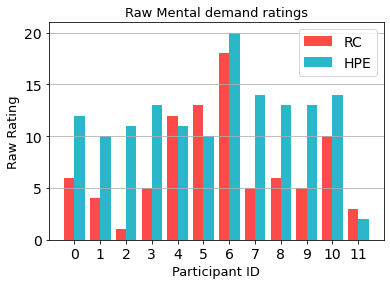

In [57]:
# Mental demand 
X = np.arange(1,12)
md_raw_rc  = [6, 4, 1, 5, 12, 13, 18, 5, 6, 5, 10, 3]
md_raw_hpe = [12, 10, 11, 13, 11, 10, 20, 14, 13, 13, 14, 2];

md_avg_rc = avg_list(md_raw_rc)
md_avg_hpe = avg_list(md_raw_hpe)


plot_bar(md_raw_rc, md_raw_hpe, origin_dir, "Mental demand")

## Mental demand

* 9/10 found HPE control to be more mentally demanding than RC control 
* 6/10 found HPE control to be more mentally demanding than RC control when using NASA adjusted TLX ratings 


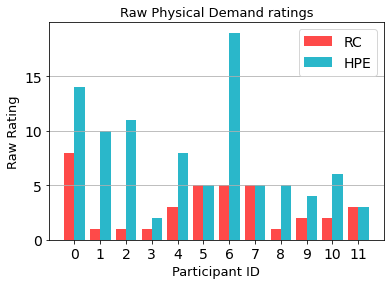

In [58]:
# Physical demand 
pd_raw_rc  = [8, 1, 1, 1, 3, 5, 5, 5, 1, 2, 2, 3]
pd_raw_hpe = [14, 10, 11, 2, 8, 5, 19, 5, 5, 4, 6, 3]
pd_avg_rc = avg_list(pd_raw_rc)
pd_avg_hpe = avg_list(pd_raw_hpe)

plot_bar(pd_raw_rc, pd_raw_hpe, origin_dir, "Physical Demand")

# Physical demand 

* It's clear that everyone found HPE control more phisically demanding than RC control 
* It's harder to move arms than fingers


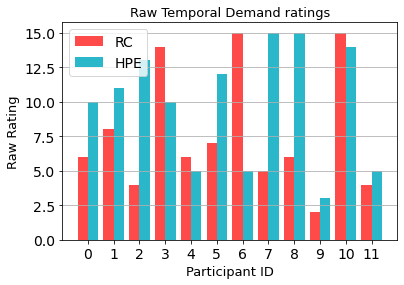

In [59]:
# Temporal Demand 

td_raw_rc  = [6, 8, 4, 14, 6, 7, 15, 5, 6, 2, 15, 4]; 
td_raw_hpe = [10, 11, 13 ,10, 5, 12, 5, 15, 15, 3, 14 ,5]; 

td_avg_rc = avg_list(td_raw_rc)
td_avg_hpe = avg_list(td_raw_hpe)


plot_bar(td_raw_rc, td_raw_hpe, origin_dir, "Temporal Demand")

# Temporal demand

There was no time pressure to finish maze in some amounted time. Nobody was given instructions to be as fast as he can, however, I've informed participants that we measure time neccessary to pass maze. 

Mixed results, some people felt more pressure when using RC some when using HPE. One of the reasons that may be the case is that when using HPE, you're more mentally and phisically challenged, therefore, less cognitive resources remain to associate with temporal demand. 

Results are mixed, and there is hard to reach clear conclusion just by examining these graphs regarding temporal demand. 

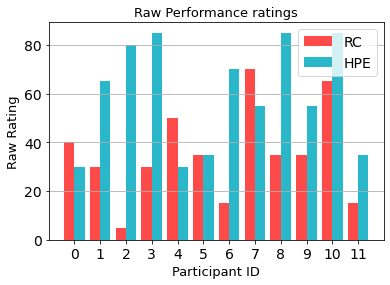

In [60]:
# Performance
# Scale is inverted (good - poor)

p_raw_rc  =  [8, 6, 1, 6, 10, 7, 3, 14, 7, 7, 13, 3]
p_raw_hpe = [6, 13, 16, 17, 6, 7, 14, 11, 17, 11, 17, 7]

p_avg_rc = avg_list(p_raw_rc)
p_avg_hpe = avg_list(p_raw_hpe)

p_adjusted_rc = [40,24,4,30,16,24,40,36,12,28 ]
p_adjusted_hpe = [18,52,0,72,0,51,24,51,28,21]

p_raw_rc  = [i * 5 for i in p_raw_rc]
p_raw_hpe = [i * 5 for i in p_raw_hpe]


plot_bar(p_raw_rc, p_raw_hpe, origin_dir, "Performance")

# Performance rating 

Performance rating scale. Most of the people felt that they performed better using RC control compared to HPE control. Performance scale is inverted (bad --> good) where higher score means better performance. More overall taskload -> better performance perception? 

### Raw ratings: 
 * 7/10 people thought they performed better with HPE compared to RC 
 * 1/10 though that performance was same with RC and HPE
 * 3/10 people found performance with RC control better 
 
### Adjusted ratings: 
 * 5/10 people think they performed better with HPE compared to RC 
 * 5/10 people think they performed better with RC than with HPE (however, overall HPE performance ratings are much higher than with RC) 
 

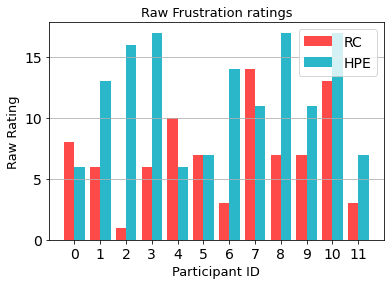

In [61]:
# Frustration 

f_raw_rc = [8, 6, 1, 6, 10, 7, 3, 14, 7, 7, 13, 3]
f_raw_hpe = [6, 13, 16, 17, 6, 7, 14, 11, 17, 11, 17, 7]

f_avg_rc = avg_list(f_raw_rc)
f_avg_hpe = avg_list(f_raw_hpe)


plot_bar(f_raw_rc, f_raw_hpe, origin_dir, "Frustration")

# Frustration 

* 9/10 People found HPE control more frustrating than RC control 

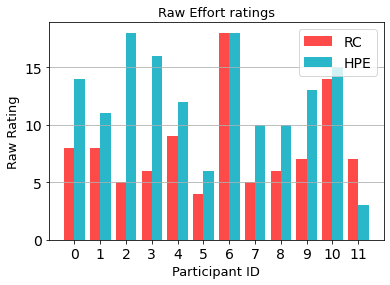

In [62]:
# Effort --> Check data for effort! 


effort_raw_rc  = [8,8,5,6,9,4,18,5,6,7,14,7]
effort_raw_hpe = [14, 11, 18, 16, 12, 6, 18, 10, 10, 13, 15, 3]

effort_avg_rc = avg_list(effort_raw_rc)
effort_avg_hpe = avg_list(effort_raw_hpe)

plot_bar(effort_raw_rc, effort_raw_hpe, origin_dir, "Effort")

# Effort

* 9/10 percieved that there's more effort neccessary for HPE control than for RC control 

## Plot plots on subplots :) 

Plot RAW and Adjusted NASA TLX on 2x1 plots to fit them in paper better. 


### TODO: 

- [x] Refactor the code 
- [x] Add methods for time cropping (when conditions satisfied) 
- [ ] Find a way to evaluate linear relationship between NASA TLX and time neccessary for passing labyrinth 
- [ ] Add it into paper 
- [x] Add start time into calculation and take in consideration only end time regarding conditions

# Algorithm dev

### Test zone definiton 

This part contains small code snippet for zone definition on image plane 

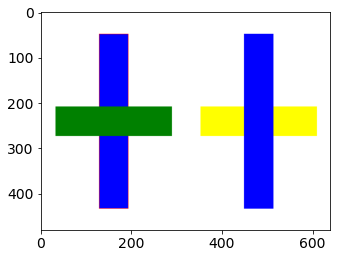

In [63]:
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import numpy as np


def define_zones(img_width, img_height, edge_offset, rect_width):
        
        # img center
        cx, cy = img_width/2, img_height/2
        # 1st zone
        cx1, cy1 = cx/2, cy/2
        # 2nd zone
        cx2, cy2 = cx + cx1, cy + cy1
        
        # Define offsets from edge
        if edge_offset < 1: 
            height_edge = edge_offset * img_height
            width_edge = edge_offset/2 * img_width

        # Zone definition 
        if rect_width < 1: 
            r_width = rect_width * img_width

        height_rect = ((cx1 - r_width, height_edge), (cx1 + r_width, img_height - height_edge))
        yaw_rect = ((width_edge, cy - r_width), (cx - width_edge, cy + r_width))
        pitch_rect = ((cx2 - r_width, height_edge), (cx2 + r_width, img_height - height_edge))
        roll_rect = ((cx + width_edge, cy-r_width), (img_width - width_edge), (cy + r_width))
        
        return height_rect, yaw_rect, pitch_rect, roll_rect

img_height = 480
img_width = 640
img = Image.new('RGB', (img_width, img_height), color = 'white')

height_rect, yaw_rect, pitch_rect, roll_rect = define_zones(img_width, img_height, 0.1, 0.05)

img1 = ImageDraw.Draw(img)  
img1.rectangle(height_rect, fill ="blue", outline ="red")
img1.rectangle(yaw_rect, fill="green")
img1.rectangle(roll_rect, fill="yellow")
img1.rectangle(pitch_rect, fill="blue")
imshow(np.asarray(img))

Awesome plotting materials can be found here: 

* https://jingwen-z.github.io/data-viz-with-matplotlib-series8-radar-chart/ 
* https://www.scribbr.com/statistics/statistical-tests/ 



['PD', 'TD', 'MD', 'F', 'E', 'P']
[7.666666666666667, 9.833333333333334, 11.916666666666666, 11.833333333333334, 12.166666666666666, 11.833333333333334, 7.666666666666667]
[3.0833333333333335, 7.666666666666667, 7.333333333333333, 7.083333333333333, 8.083333333333334, 7.083333333333333, 3.0833333333333335]


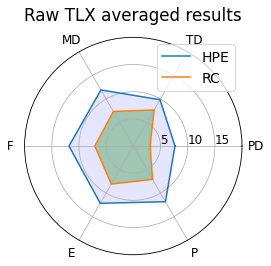

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
df = pd.DataFrame({
'group': ['A','B'],
'PD': [pd_avg_hpe, pd_avg_rc],
'TD': [td_avg_hpe, td_avg_rc],
'MD': [md_avg_hpe, md_avg_rc],
'F': [f_avg_hpe, f_avg_rc],
'E': [effort_avg_hpe, effort_avg_rc],
'P': [p_avg_hpe, p_avg_rc]
})

 
# number of variable
categories=list(df)[1:]
print(categories)
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values0=df.loc[0].drop('group').values.flatten().tolist()
values0 += values0[:1]
values0
print(values0)

values1 = df.loc[1].drop('group').values.flatten().tolist()
values1 += values1[:1]
values1
print(values1)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='black', size=12)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([5, 10, 15, 20], ["5","10", "15"], color="black", size=12)
plt.ylim(0, 20)
 
# Plot data
ax.plot(angles, values0, linewidth=1.5, linestyle='solid', label="HPE")
ax.fill(angles, values0, 'b', alpha=0.1)

ax.plot(angles, values1, linewidth=1.5, linestyle='solid', label="RC")
ax.fill(angles, values1, 'g', alpha=0.3)

# Show the graph
plt.legend(loc="best")
plt.title("Raw TLX averaged results")
plt.savefig("{}/sst_plt.svg".format(origin_dir))
plt.show()


In [52]:
def avg_list(list_):
    
    return sum(list_)/len(list_)

NameError: name 'rc_correcte' is not defined